# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [1]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [2]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([360,640,3])           # Holding variable for image concatenation
c2 = np.empty([370,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [3]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
        mask_top_right_x = 680
        mask_bottom_right_x = 1190
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
        mask_bottom_right_x = 1150
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)    
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [4]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img4) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
#    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (150,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [5]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
    print("Inside reset")
    drive_log.write("@ " + str(len(detected_lines)) + " - Inside reset\n")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,(640, 360))
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [37]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
#    print("inside sanity")
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
#            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            drive_log.write("@ " + str(len(detected_lines)) + " > low pass failure : " 
                            + str(len(l.leftx)) + " " + str(len(l.rightx)) + "\n")
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.2):
            good_lane = False
#            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > lane width failure : " 
                            + str(l.lane_width) + "\n")
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 20000 or l.right_curverad > 20000:
            good_lane = False
#            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > curve check failure : " 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 10000:
            good_lane = False
#            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > left and right curves similarity failure :" 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
#            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            drive_log.write("@ " + str(len(detected_lines)) + " > 2nd order coefficient similarity failure :" 
                            + str(l.left_fit[0]) + " " + str(l.right_fit[0]) + "\n")
            break
            
#        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
        if abs(l.left_fit[1] - l.right_fit[1]) > 0.35:
            good_lane = False
#            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            drive_log.write("@ " + str(len(detected_lines)) + " > 1st order coefficient similarity failure :" 
                            + str(l.left_fit[1]) + " " + str(l.right_fit[1]) + "\n")
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
#                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - lane offset variation high : " 
                                    + str(l.center_offset_m) + " " + str(detected_lines[-1].center_offset_m) + "\n")
                    break

            # Is the left curvature offset reasonable from prev frame
                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
#                          l.left_curverad, detected_lines[-1].left_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - left curve variation high : " 
                                    + str(l.left_curverad) + " " + str(detected_lines[-1].left_curverad) + "\n")
                    break
            
            # Is the right curvature offset reasonable from prev frame
                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
#                          l.right_curverad, detected_lines[-1].right_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - right curve variation high : " 
                                    + str(l.right_curverad) + " " + str(detected_lines[-1].right_curverad) + "\n")
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [40]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    print("inside get line fit")
    
#    showGrayImg(binary_warped)
    global reset_lanes
    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)

    print(len(detected_lines)) 
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(image.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    l.smooth_left_fit = left_fit[:]
    l.smooth_right_fit = right_fit[:]

    print(len(detected_lines))
    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
        print("inside first frame")
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,(640, 360))
    c1.fill(255)
    print(len(detected_lines))
    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines)), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (300,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (300,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (300,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (300,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (300,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print("c1 =", c1.shape)
#    showImg(c1)

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_left_fit = l.smooth_left_fit + line.left_fit
            l.smooth_right_fit = l.smooth_right_fit + line.right_fit
            i += 1
            if i >= 5:
                 break 
        l.smooth_left_fit = (l.smooth_left_fit) / i
        l.smooth_right_fit = (l.smooth_right_fit) / i
    else:
        l.continous_bad_lanes += 1
        print("inside bad lane section", l.continous_bad_lanes)
        if l.continous_bad_lanes > 5: 
            global reset_lanes
            reset_lanes = True
            print("inside bad lane threshold", l.continous_bad_lanes, reset_lanes)
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    print("reset final = ", reset_lanes)
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

<ipython-input-40-29093c19a16f>:166: SyntaxWarning: name 'reset_lanes' is used prior to global declaration
  global reset_lanes


## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [8]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    print("reset status after call = ", reset_lanes)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Caliberate Camera
This section caliberates the camera by using chessboard images so that images can be undistorted

In [9]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be undistorted"""

def caliberate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
#    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [10]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,483],[736,483],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
#        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    print("Perspective M = ", perspective_M)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    """
    
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [11]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
#    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
#    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Explore input image characteristics
Read a sample image to find out its shape and type

shape of image object =  (720, 1280, 3)
type of image object =  <class 'numpy.ndarray'>


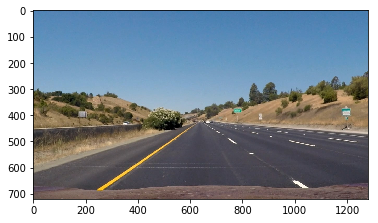

In [12]:
image = cv2.imread("test_images\\straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("shape of image object = ", image.shape)
print("type of image object = ", type(image))
showImg(image)   

## Validate pipeline on test images

Use test images to validate the pipeline.


Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.67753151e-01  -1.41127605e+00   8.80171743e+02]
 [ -5.44009282e-15  -1.92959176e+00   9.31173038e+02]
 [ -8.13151629e-18  -2.24012072e-03   1.00000000e+00]]
Baseline mid, left, center =  640 407 864
Baeline Lane width in pixels =  457
reset status True
Inside reset
0
0
inside first frame
0
reset final =  False
reset status after call =  False


C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


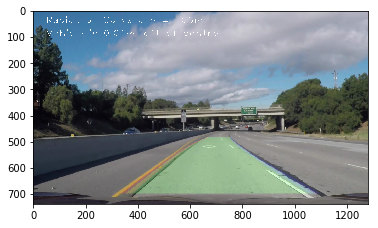

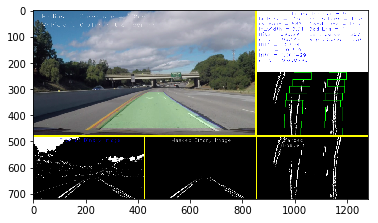

Pair of lanes detected =  1


In [39]:
reset_lanes = True
detected_lines = []

drive_log = open("i_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

image = cv2.imread('test_images/c2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

marked_img = lane_marker_pipeline(image)

showImg(marked_img)
combined_imgs = img_collage(marked_img)
showImg(combined_imgs)
combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
cv2.imwrite('text_test.jpg',combined_imgs)
#drive_log.close()

"""
images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
 
"""

print("Pair of lanes detected = ", len(detected_lines))

inside get line fit
reset status False
7
7
inside sanity
7
inside for with i value of  1 [  4.28982251e-04  -5.53750134e-01   5.93286130e+02]
inside for with i value of  2 [  4.28982251e-04  -5.53750134e-01   5.93286130e+02]
inside for with i value of  3 [  4.28982251e-04  -5.53750134e-01   5.93286130e+02]
inside for with i value of  4 [  4.28982251e-04  -5.53750134e-01   5.93286130e+02]
coeff in good lane after smoothing =  [  4.28982251e-04  -5.53750134e-01   5.93286130e+02]
reset final =  False
reset status after call =  False


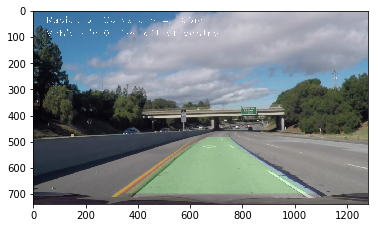

In [36]:
marked_img = lane_marker_pipeline(image)
showImg(marked_img)
#drive_log.close()

## Test lane finding pipeline on Videos

This section reads the clips from the video, passes them to the pipeline and creates a video out of the pipeline outputs



In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

## Project Video

Applying lane marking pipeline on project video.

In [43]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("p_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("P3.mp4")
#clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))
drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.79366668e-01  -1.50060593e+00   8.73272564e+02]
 [ -2.77555756e-15  -1.90744658e+00   8.53880078e+02]
 [ -4.66206934e-18  -2.37856879e-03   1.00000000e+00]]
Baseline mid, left, center =  640 398 880
Baeline Lane width in pixels =  482
reset status True
Inside reset
0
0
inside first frame
0
reset final =  False
reset status after call =  False
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                                                                                                                                               | 0/315 [00:00<?, ?it/s]

reset status False
1
1
1
reset final =  False
reset status after call =  False


  0%|▋                                                                                                                                                                                                      | 1/315 [00:00<02:09,  2.42it/s]

reset status False
2
2
2
reset final =  False
reset status after call =  False


  1%|█▎                                                                                                                                                                                                     | 2/315 [00:00<02:08,  2.44it/s]

reset status False
3
3
3
reset final =  False
reset status after call =  False


  1%|█▉                                                                                                                                                                                                     | 3/315 [00:01<02:05,  2.49it/s]

reset status False
4
4
4
reset final =  False
reset status after call =  False


  1%|██▌                                                                                                                                                                                                    | 4/315 [00:01<02:04,  2.51it/s]

reset status False
5
5
5
reset final =  False
reset status after call =  False


  2%|███▏                                                                                                                                                                                                   | 5/315 [00:02<02:05,  2.47it/s]

reset status False
6
6
6
reset final =  False
reset status after call =  False


  2%|███▊                                                                                                                                                                                                   | 6/315 [00:02<02:03,  2.50it/s]

reset status False
7
7
7
reset final =  False
reset status after call =  False


  2%|████▍                                                                                                                                                                                                  | 7/315 [00:02<02:02,  2.51it/s]

reset status False
8
8
8
reset final =  False
reset status after call =  False


  3%|█████                                                                                                                                                                                                  | 8/315 [00:03<02:04,  2.47it/s]

reset status False
9
9
9
reset final =  False
reset status after call =  False


  3%|█████▋                                                                                                                                                                                                 | 9/315 [00:03<02:02,  2.50it/s]

reset status False
10
10
10
reset final =  False
reset status after call =  False


  3%|██████▎                                                                                                                                                                                               | 10/315 [00:03<01:59,  2.54it/s]

reset status False
11
11
11
reset final =  False
reset status after call =  False


  3%|██████▉                                                                                                                                                                                               | 11/315 [00:04<01:59,  2.55it/s]

reset status False
12
12
12
reset final =  False
reset status after call =  False


  4%|███████▌                                                                                                                                                                                              | 12/315 [00:04<01:59,  2.53it/s]

reset status False
13
13
13
reset final =  False
reset status after call =  False


  4%|████████▏                                                                                                                                                                                             | 13/315 [00:05<02:00,  2.51it/s]

reset status False
14
14
14
reset final =  False
reset status after call =  False


  4%|████████▊                                                                                                                                                                                             | 14/315 [00:05<02:00,  2.49it/s]

reset status False
15
15
15
reset final =  False
reset status after call =  False


  5%|█████████▍                                                                                                                                                                                            | 15/315 [00:05<02:01,  2.47it/s]

reset status False
16
16
16
reset final =  False
reset status after call =  False


  5%|██████████                                                                                                                                                                                            | 16/315 [00:06<02:00,  2.49it/s]

reset status False
17
17
17
reset final =  False
reset status after call =  False


  5%|██████████▋                                                                                                                                                                                           | 17/315 [00:06<01:59,  2.49it/s]

reset status False
18
18
18
reset final =  False
reset status after call =  False


  6%|███████████▎                                                                                                                                                                                          | 18/315 [00:07<01:58,  2.51it/s]

reset status False
19
19
19
reset final =  False
reset status after call =  False


  6%|███████████▉                                                                                                                                                                                          | 19/315 [00:07<01:58,  2.50it/s]

reset status False
20
20
20
reset final =  False
reset status after call =  False


  6%|████████████▌                                                                                                                                                                                         | 20/315 [00:07<01:58,  2.50it/s]

reset status False
21
21
21
reset final =  False
reset status after call =  False


  7%|█████████████▏                                                                                                                                                                                        | 21/315 [00:08<01:56,  2.52it/s]

reset status False
22
22
22
reset final =  False
reset status after call =  False


  7%|█████████████▊                                                                                                                                                                                        | 22/315 [00:08<01:56,  2.51it/s]

reset status False
23
23
23
reset final =  False
reset status after call =  False


  7%|██████████████▍                                                                                                                                                                                       | 23/315 [00:09<01:56,  2.50it/s]

reset status False
24
24
24
reset final =  False
reset status after call =  False


  8%|███████████████                                                                                                                                                                                       | 24/315 [00:09<01:56,  2.51it/s]

reset status False
25
25
25
reset final =  False
reset status after call =  False


  8%|███████████████▋                                                                                                                                                                                      | 25/315 [00:09<01:56,  2.50it/s]

reset status False
26
26
26
reset final =  False
reset status after call =  False


  8%|████████████████▎                                                                                                                                                                                     | 26/315 [00:10<01:54,  2.52it/s]

reset status False
27
27
27
reset final =  False
reset status after call =  False


  9%|████████████████▉                                                                                                                                                                                     | 27/315 [00:10<01:55,  2.49it/s]

reset status False
28
28
28
reset final =  False
reset status after call =  False


  9%|█████████████████▌                                                                                                                                                                                    | 28/315 [00:11<01:56,  2.46it/s]

reset status False
29
29
29
inside bad lane section 1
reset final =  False
reset status after call =  False


  9%|██████████████████▏                                                                                                                                                                                   | 29/315 [00:11<01:55,  2.47it/s]

reset status False
30
30
30
inside bad lane section 2
reset final =  False
reset status after call =  False


 10%|██████████████████▊                                                                                                                                                                                   | 30/315 [00:12<01:57,  2.42it/s]

reset status False
31
31
31
inside bad lane section 3
reset final =  False
reset status after call =  False


 10%|███████████████████▍                                                                                                                                                                                  | 31/315 [00:12<01:56,  2.43it/s]

reset status False
32
32
32
inside bad lane section 4
reset final =  False
reset status after call =  False


 10%|████████████████████                                                                                                                                                                                  | 32/315 [00:12<01:55,  2.45it/s]

reset status False
33
33
33
inside bad lane section 5
reset final =  False
reset status after call =  False


 10%|████████████████████▋                                                                                                                                                                                 | 33/315 [00:13<01:56,  2.42it/s]

reset status False
34
34
34
inside bad lane section 6
inside bad lane threshold 6 True
reset final =  True
reset status after call =  True


 11%|█████████████████████▎                                                                                                                                                                                | 34/315 [00:13<01:56,  2.41it/s]

reset status True
Inside reset
35
35
35
reset final =  False
reset status after call =  False


 11%|██████████████████████                                                                                                                                                                                | 35/315 [00:14<01:58,  2.37it/s]

reset status False
36
36
36
reset final =  False
reset status after call =  False


 11%|██████████████████████▋                                                                                                                                                                               | 36/315 [00:14<01:55,  2.42it/s]

reset status False
37
37
37
reset final =  False
reset status after call =  False


 12%|███████████████████████▎                                                                                                                                                                              | 37/315 [00:14<01:55,  2.41it/s]

reset status False
38
38
38
reset final =  False
reset status after call =  False


 12%|███████████████████████▉                                                                                                                                                                              | 38/315 [00:15<01:53,  2.44it/s]

reset status False
39
39
39
reset final =  False
reset status after call =  False


 12%|████████████████████████▌                                                                                                                                                                             | 39/315 [00:15<01:53,  2.44it/s]

reset status False
40
40
40
reset final =  False
reset status after call =  False


 13%|█████████████████████████▏                                                                                                                                                                            | 40/315 [00:16<01:50,  2.49it/s]

reset status False
41
41
41
reset final =  False
reset status after call =  False


 13%|█████████████████████████▊                                                                                                                                                                            | 41/315 [00:16<01:51,  2.45it/s]

reset status False
42
42
42
reset final =  False
reset status after call =  False


 13%|██████████████████████████▍                                                                                                                                                                           | 42/315 [00:16<01:50,  2.47it/s]

reset status False
43
43
43
reset final =  False
reset status after call =  False


 14%|███████████████████████████                                                                                                                                                                           | 43/315 [00:17<01:50,  2.46it/s]

reset status False
44
44
44
reset final =  False
reset status after call =  False


 14%|███████████████████████████▋                                                                                                                                                                          | 44/315 [00:17<01:50,  2.45it/s]

reset status False
45
45
45
reset final =  False
reset status after call =  False


 14%|████████████████████████████▎                                                                                                                                                                         | 45/315 [00:18<01:48,  2.48it/s]

reset status False
46
46
46
reset final =  False
reset status after call =  False


 15%|████████████████████████████▉                                                                                                                                                                         | 46/315 [00:18<01:48,  2.48it/s]

reset status False
47
47
47
reset final =  False
reset status after call =  False


 15%|█████████████████████████████▌                                                                                                                                                                        | 47/315 [00:18<01:49,  2.46it/s]

reset status False
48
48
48
reset final =  False
reset status after call =  False


 15%|██████████████████████████████▏                                                                                                                                                                       | 48/315 [00:19<01:51,  2.39it/s]

reset status False
49
49
49
reset final =  False
reset status after call =  False


 16%|██████████████████████████████▊                                                                                                                                                                       | 49/315 [00:19<01:49,  2.43it/s]

reset status False
50
50
50
reset final =  False
reset status after call =  False


 16%|███████████████████████████████▍                                                                                                                                                                      | 50/315 [00:20<01:47,  2.46it/s]

reset status False
51
51
51
reset final =  False
reset status after call =  False


 16%|████████████████████████████████                                                                                                                                                                      | 51/315 [00:20<01:48,  2.43it/s]

reset status False
52
52
52
reset final =  False
reset status after call =  False


 17%|████████████████████████████████▋                                                                                                                                                                     | 52/315 [00:21<01:47,  2.46it/s]

reset status False
53
53
53
reset final =  False
reset status after call =  False


 17%|█████████████████████████████████▎                                                                                                                                                                    | 53/315 [00:21<01:47,  2.43it/s]

reset status False
54
54
54
reset final =  False
reset status after call =  False


 17%|█████████████████████████████████▉                                                                                                                                                                    | 54/315 [00:21<01:47,  2.43it/s]

reset status False
55
55
55
inside bad lane section 1
reset final =  False
reset status after call =  False


 17%|██████████████████████████████████▌                                                                                                                                                                   | 55/315 [00:22<01:47,  2.42it/s]

reset status False
56
56
56
reset final =  False
reset status after call =  False


 18%|███████████████████████████████████▏                                                                                                                                                                  | 56/315 [00:22<01:46,  2.42it/s]

reset status False
57
57
57
inside bad lane section 1
reset final =  False
reset status after call =  False


 18%|███████████████████████████████████▊                                                                                                                                                                  | 57/315 [00:23<01:45,  2.44it/s]

reset status False
58
58
58
inside bad lane section 2
reset final =  False
reset status after call =  False


 18%|████████████████████████████████████▍                                                                                                                                                                 | 58/315 [00:23<01:47,  2.40it/s]

reset status False
59
59
59
inside bad lane section 3
reset final =  False
reset status after call =  False


 19%|█████████████████████████████████████                                                                                                                                                                 | 59/315 [00:23<01:45,  2.42it/s]

reset status False
60
60
60
inside bad lane section 4
reset final =  False
reset status after call =  False


 19%|█████████████████████████████████████▋                                                                                                                                                                | 60/315 [00:24<01:43,  2.45it/s]

reset status False
61
61
61
inside bad lane section 5
reset final =  False
reset status after call =  False


 19%|██████████████████████████████████████▎                                                                                                                                                               | 61/315 [00:24<01:44,  2.42it/s]

reset status False
62
62
62
inside bad lane section 6
inside bad lane threshold 6 True
reset final =  True
reset status after call =  True


 20%|██████████████████████████████████████▉                                                                                                                                                               | 62/315 [00:25<01:45,  2.40it/s]

reset status True
Inside reset
63
63
63
reset final =  False
reset status after call =  False


 20%|███████████████████████████████████████▌                                                                                                                                                              | 63/315 [00:25<01:45,  2.39it/s]

reset status False
64
64
64
reset final =  False
reset status after call =  False


 20%|████████████████████████████████████████▏                                                                                                                                                             | 64/315 [00:25<01:43,  2.43it/s]

reset status False
65
65
65
reset final =  False
reset status after call =  False


 21%|████████████████████████████████████████▊                                                                                                                                                             | 65/315 [00:26<01:41,  2.47it/s]

reset status False
66
66
66
reset final =  False
reset status after call =  False


 21%|█████████████████████████████████████████▍                                                                                                                                                            | 66/315 [00:26<01:39,  2.50it/s]

reset status False
67
67
67
reset final =  False
reset status after call =  False


 21%|██████████████████████████████████████████                                                                                                                                                            | 67/315 [00:27<01:38,  2.51it/s]

reset status False
68
68
68
reset final =  False
reset status after call =  False


 22%|██████████████████████████████████████████▋                                                                                                                                                           | 68/315 [00:27<01:39,  2.49it/s]

reset status False
69
69
69
reset final =  False
reset status after call =  False


 22%|███████████████████████████████████████████▎                                                                                                                                                          | 69/315 [00:28<01:40,  2.45it/s]

reset status False
70
70
70
reset final =  False
reset status after call =  False


 22%|████████████████████████████████████████████                                                                                                                                                          | 70/315 [00:28<01:39,  2.45it/s]

reset status False
71
71
71
reset final =  False
reset status after call =  False


 23%|████████████████████████████████████████████▋                                                                                                                                                         | 71/315 [00:28<01:37,  2.50it/s]

reset status False
72
72
72
reset final =  False
reset status after call =  False


 23%|█████████████████████████████████████████████▎                                                                                                                                                        | 72/315 [00:29<01:37,  2.48it/s]

reset status False
73
73
73
reset final =  False
reset status after call =  False


 23%|█████████████████████████████████████████████▉                                                                                                                                                        | 73/315 [00:29<01:38,  2.46it/s]

reset status False
74
74
74
reset final =  False
reset status after call =  False


 23%|██████████████████████████████████████████████▌                                                                                                                                                       | 74/315 [00:30<01:37,  2.46it/s]

reset status False
75
75
75
reset final =  False
reset status after call =  False


 24%|███████████████████████████████████████████████▏                                                                                                                                                      | 75/315 [00:30<01:36,  2.48it/s]

reset status False
76
76
76
reset final =  False
reset status after call =  False


 24%|███████████████████████████████████████████████▊                                                                                                                                                      | 76/315 [00:30<01:36,  2.47it/s]

reset status False
77
77
77
reset final =  False
reset status after call =  False


 24%|████████████████████████████████████████████████▍                                                                                                                                                     | 77/315 [00:31<01:37,  2.45it/s]

reset status False
78
78
78
reset final =  False
reset status after call =  False


 25%|█████████████████████████████████████████████████                                                                                                                                                     | 78/315 [00:31<01:37,  2.43it/s]

reset status False
79
79
79
reset final =  False
reset status after call =  False


 25%|█████████████████████████████████████████████████▋                                                                                                                                                    | 79/315 [00:32<01:37,  2.43it/s]

reset status False
80
80
80
reset final =  False
reset status after call =  False


 25%|██████████████████████████████████████████████████▎                                                                                                                                                   | 80/315 [00:32<01:37,  2.42it/s]

reset status False
81
81
81
reset final =  False
reset status after call =  False


 26%|██████████████████████████████████████████████████▉                                                                                                                                                   | 81/315 [00:32<01:36,  2.44it/s]

reset status False
82
82
82
reset final =  False
reset status after call =  False


 26%|███████████████████████████████████████████████████▌                                                                                                                                                  | 82/315 [00:33<01:37,  2.39it/s]

reset status False
83
83
83
reset final =  False
reset status after call =  False


 26%|████████████████████████████████████████████████████▏                                                                                                                                                 | 83/315 [00:33<01:36,  2.39it/s]

reset status False
84
84
84
reset final =  False
reset status after call =  False


 27%|████████████████████████████████████████████████████▊                                                                                                                                                 | 84/315 [00:34<01:36,  2.40it/s]

reset status False
85
85
85
reset final =  False
reset status after call =  False


 27%|█████████████████████████████████████████████████████▍                                                                                                                                                | 85/315 [00:34<01:35,  2.41it/s]

reset status False
86
86
86
reset final =  False
reset status after call =  False


 27%|██████████████████████████████████████████████████████                                                                                                                                                | 86/315 [00:34<01:34,  2.43it/s]

reset status False
87
87
87
reset final =  False
reset status after call =  False


 28%|██████████████████████████████████████████████████████▋                                                                                                                                               | 87/315 [00:35<01:40,  2.27it/s]

reset status False
88
88
88
reset final =  False
reset status after call =  False


 28%|███████████████████████████████████████████████████████▎                                                                                                                                              | 88/315 [00:35<01:36,  2.35it/s]

reset status False
89
89
89
reset final =  False
reset status after call =  False


 28%|███████████████████████████████████████████████████████▉                                                                                                                                              | 89/315 [00:36<01:35,  2.37it/s]

reset status False
90
90
90
reset final =  False
reset status after call =  False


 29%|████████████████████████████████████████████████████████▌                                                                                                                                             | 90/315 [00:36<01:33,  2.41it/s]

reset status False
91
91
91
reset final =  False
reset status after call =  False


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                            | 91/315 [00:37<01:30,  2.47it/s]

reset status False
92
92
92
reset final =  False
reset status after call =  False


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                            | 92/315 [00:37<01:31,  2.45it/s]

reset status False
93
93
93
reset final =  False
reset status after call =  False


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                           | 93/315 [00:37<01:31,  2.41it/s]

reset status False
94
94
94
reset final =  False
reset status after call =  False


 30%|███████████████████████████████████████████████████████████                                                                                                                                           | 94/315 [00:38<01:29,  2.46it/s]

reset status False
95
95
95
reset final =  False
reset status after call =  False


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                          | 95/315 [00:38<01:28,  2.48it/s]

reset status False
96
96
96
reset final =  False
reset status after call =  False


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                         | 96/315 [00:39<01:28,  2.47it/s]

reset status False
97
97
97
reset final =  False
reset status after call =  False


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                         | 97/315 [00:39<01:27,  2.49it/s]

reset status False
98
98
98
reset final =  False
reset status after call =  False


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                        | 98/315 [00:39<01:28,  2.45it/s]

reset status False
99
99
99
reset final =  False
reset status after call =  False


 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                       | 99/315 [00:40<01:26,  2.48it/s]

reset status False
100
100
100
reset final =  False
reset status after call =  False


 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                      | 100/315 [00:40<01:27,  2.45it/s]

reset status False
101
101
101
reset final =  False
reset status after call =  False


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                     | 101/315 [00:41<01:25,  2.49it/s]

reset status False
102
102
102
reset final =  False
reset status after call =  False


 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                     | 102/315 [00:41<01:27,  2.45it/s]

reset status False
103
103
103
reset final =  False
reset status after call =  False


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                    | 103/315 [00:41<01:25,  2.48it/s]

reset status False
104
104
104
reset final =  False
reset status after call =  False


 33%|█████████████████████████████████████████████████████████████████                                                                                                                                    | 104/315 [00:42<01:24,  2.50it/s]

reset status False
105
105
105
reset final =  False
reset status after call =  False


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                   | 105/315 [00:42<01:24,  2.47it/s]

reset status False
106
106
106
reset final =  False
reset status after call =  False


 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                  | 106/315 [00:43<01:25,  2.44it/s]

reset status False
107
107
107
reset final =  False
reset status after call =  False


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                  | 107/315 [00:43<01:24,  2.46it/s]

reset status False
108
108
108
reset final =  False
reset status after call =  False


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                 | 108/315 [00:43<01:24,  2.46it/s]

reset status False
109
109
109
reset final =  False
reset status after call =  False


 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                                | 109/315 [00:44<01:25,  2.42it/s]

reset status False
110
110
110
reset final =  False
reset status after call =  False


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                                | 110/315 [00:44<01:25,  2.40it/s]

reset status False
111
111
111
reset final =  False
reset status after call =  False


 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                               | 111/315 [00:45<01:24,  2.41it/s]

reset status False
112
112
112
reset final =  False
reset status after call =  False


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                               | 112/315 [00:45<01:24,  2.40it/s]

reset status False
113
113
113
reset final =  False
reset status after call =  False


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                              | 113/315 [00:46<01:25,  2.36it/s]

reset status False
114
114
114
reset final =  False
reset status after call =  False


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                             | 114/315 [00:46<01:25,  2.36it/s]

reset status False
115
115
115
reset final =  False
reset status after call =  False


 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 115/315 [00:47<01:29,  2.23it/s]

reset status False
116
116
116
reset final =  False
reset status after call =  False


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 116/315 [00:47<01:27,  2.29it/s]

reset status False
117
117
117
reset final =  False
reset status after call =  False


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 117/315 [00:47<01:26,  2.30it/s]

reset status False
118
118
118
reset final =  False
reset status after call =  False


 37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 118/315 [00:48<01:23,  2.35it/s]

reset status False
119
119
119
reset final =  False
reset status after call =  False


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 119/315 [00:48<01:24,  2.33it/s]

reset status False
120
120
120
reset final =  False
reset status after call =  False


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                          | 120/315 [00:49<01:23,  2.34it/s]

reset status False
121
121
121
reset final =  False
reset status after call =  False


 38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 121/315 [00:49<01:21,  2.37it/s]

reset status False
122
122
122
reset final =  False
reset status after call =  False


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 122/315 [00:49<01:19,  2.42it/s]

reset status False
123
123
123
reset final =  False
reset status after call =  False


 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 123/315 [00:50<01:19,  2.41it/s]

reset status False
124
124
124
reset final =  False
reset status after call =  False


 39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 124/315 [00:50<01:20,  2.39it/s]

reset status False
125
125
125
reset final =  False
reset status after call =  False


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 125/315 [00:51<01:19,  2.38it/s]

reset status False
126
126
126
reset final =  False
reset status after call =  False


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 126/315 [00:51<01:19,  2.39it/s]

reset status False
127
127
127
reset final =  False
reset status after call =  False


 40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 127/315 [00:52<01:19,  2.36it/s]

reset status False
128
128
128
reset final =  False
reset status after call =  False


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 128/315 [00:52<01:17,  2.43it/s]

reset status False
129
129
129
reset final =  False
reset status after call =  False


 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 129/315 [00:52<01:17,  2.40it/s]

reset status False
130
130
130
reset final =  False
reset status after call =  False


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 130/315 [00:53<01:17,  2.38it/s]

reset status False
131
131
131
reset final =  False
reset status after call =  False


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 131/315 [00:53<01:17,  2.39it/s]

reset status False
132
132
132
reset final =  False
reset status after call =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 132/315 [00:54<01:18,  2.34it/s]

reset status False
133
133
133
reset final =  False
reset status after call =  False


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 133/315 [00:54<01:16,  2.38it/s]

reset status False
134
134
134
reset final =  False
reset status after call =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 134/315 [00:54<01:16,  2.38it/s]

reset status False
135
135
135
reset final =  False
reset status after call =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 135/315 [00:55<01:16,  2.36it/s]

reset status False
136
136
136
reset final =  False
reset status after call =  False


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 136/315 [00:55<01:15,  2.36it/s]

reset status False
137
137
137
reset final =  False
reset status after call =  False


 43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 137/315 [00:56<01:14,  2.38it/s]

reset status False
138
138
138
reset final =  False
reset status after call =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 138/315 [00:56<01:13,  2.42it/s]

reset status False
139
139
139
reset final =  False
reset status after call =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 139/315 [00:57<01:12,  2.43it/s]

reset status False
140
140
140
reset final =  False
reset status after call =  False


 44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 140/315 [00:57<01:11,  2.46it/s]

reset status False
141
141
141
reset final =  False
reset status after call =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 141/315 [00:57<01:11,  2.43it/s]

reset status False
142
142
142
reset final =  False
reset status after call =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 142/315 [00:58<01:12,  2.40it/s]

reset status False
143
143
143
reset final =  False
reset status after call =  False


 45%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 143/315 [00:58<01:11,  2.39it/s]

reset status False
144
144
144
reset final =  False
reset status after call =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 144/315 [00:59<01:11,  2.40it/s]

reset status False
145
145
145
reset final =  False
reset status after call =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 145/315 [00:59<01:11,  2.38it/s]

reset status False
146
146
146
reset final =  False
reset status after call =  False


 46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 146/315 [00:59<01:11,  2.37it/s]

reset status False
147
147
147
reset final =  False
reset status after call =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 147/315 [01:00<01:10,  2.38it/s]

reset status False
148
148
148
reset final =  False
reset status after call =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 148/315 [01:00<01:10,  2.38it/s]

reset status False
149
149
149
reset final =  False
reset status after call =  False


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 149/315 [01:01<01:09,  2.38it/s]

reset status False
150
150
150
reset final =  False
reset status after call =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 150/315 [01:01<01:09,  2.36it/s]

reset status False
151
151
151
reset final =  False
reset status after call =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 151/315 [01:02<01:09,  2.35it/s]

reset status False
152
152
152
reset final =  False
reset status after call =  False


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 152/315 [01:02<01:08,  2.37it/s]

reset status False
153
153
153
reset final =  False
reset status after call =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 153/315 [01:02<01:08,  2.37it/s]

reset status False
154
154
154
reset final =  False
reset status after call =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 154/315 [01:03<01:07,  2.39it/s]

reset status False
155
155
155
reset final =  False
reset status after call =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 155/315 [01:03<01:07,  2.37it/s]

reset status False
156
156
156
reset final =  False
reset status after call =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 156/315 [01:04<01:06,  2.38it/s]

reset status False
157
157
157
reset final =  False
reset status after call =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 157/315 [01:04<01:06,  2.37it/s]

reset status False
158
158
158
reset final =  False
reset status after call =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 158/315 [01:05<01:07,  2.32it/s]

reset status False
159
159
159
reset final =  False
reset status after call =  False


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 159/315 [01:05<01:06,  2.34it/s]

reset status False
160
160
160
reset final =  False
reset status after call =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 160/315 [01:05<01:06,  2.35it/s]

reset status False
161
161
161
reset final =  False
reset status after call =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 161/315 [01:06<01:05,  2.36it/s]

reset status False
162
162
162
reset final =  False
reset status after call =  False


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 162/315 [01:06<01:04,  2.39it/s]

reset status False
163
163
163
reset final =  False
reset status after call =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 163/315 [01:07<01:03,  2.40it/s]

reset status False
164
164
164
reset final =  False
reset status after call =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 164/315 [01:07<01:04,  2.36it/s]

reset status False
165
165
165
reset final =  False
reset status after call =  False


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 165/315 [01:08<01:02,  2.39it/s]

reset status False
166
166
166
reset final =  False
reset status after call =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 166/315 [01:08<01:03,  2.36it/s]

reset status False
167
167
167
reset final =  False
reset status after call =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 167/315 [01:08<01:02,  2.36it/s]

reset status False
168
168
168
reset final =  False
reset status after call =  False


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 168/315 [01:09<01:01,  2.37it/s]

reset status False
169
169
169
reset final =  False
reset status after call =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 169/315 [01:09<01:01,  2.37it/s]

reset status False
170
170
170
reset final =  False
reset status after call =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 170/315 [01:10<01:01,  2.34it/s]

reset status False
171
171
171
reset final =  False
reset status after call =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 171/315 [01:10<01:01,  2.35it/s]

reset status False
172
172
172
reset final =  False
reset status after call =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 172/315 [01:10<01:00,  2.37it/s]

reset status False
173
173
173
reset final =  False
reset status after call =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 173/315 [01:11<01:00,  2.35it/s]

reset status False
174
174
174
reset final =  False
reset status after call =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 174/315 [01:11<00:59,  2.35it/s]

reset status False
175
175
175
reset final =  False
reset status after call =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 175/315 [01:12<00:59,  2.34it/s]

reset status False
176
176
176
reset final =  False
reset status after call =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 176/315 [01:12<00:59,  2.34it/s]

reset status False
177
177
177
reset final =  False
reset status after call =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 177/315 [01:13<00:59,  2.32it/s]

reset status False
178
178
178
reset final =  False
reset status after call =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 178/315 [01:13<00:58,  2.35it/s]

reset status False
179
179
179
reset final =  False
reset status after call =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 179/315 [01:13<00:57,  2.37it/s]

reset status False
180
180
180
reset final =  False
reset status after call =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 180/315 [01:14<00:57,  2.37it/s]

reset status False
181
181
181
reset final =  False
reset status after call =  False


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 181/315 [01:14<00:56,  2.38it/s]

reset status False
182
182
182
reset final =  False
reset status after call =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 182/315 [01:15<00:57,  2.33it/s]

reset status False
183
183
183
reset final =  False
reset status after call =  False


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 183/315 [01:15<00:56,  2.33it/s]

reset status False
184
184
184
reset final =  False
reset status after call =  False


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 184/315 [01:16<00:56,  2.33it/s]

reset status False
185
185
185
reset final =  False
reset status after call =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 185/315 [01:16<00:55,  2.33it/s]

reset status False
186
186
186
reset final =  False
reset status after call =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 186/315 [01:16<00:55,  2.34it/s]

reset status False
187
187
187
reset final =  False
reset status after call =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 187/315 [01:17<00:54,  2.35it/s]

reset status False
188
188
188
reset final =  False
reset status after call =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 188/315 [01:17<00:54,  2.33it/s]

reset status False
189
189
189
reset final =  False
reset status after call =  False


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 189/315 [01:18<00:53,  2.34it/s]

reset status False
190
190
190
reset final =  False
reset status after call =  False


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 190/315 [01:18<00:53,  2.35it/s]

reset status False
191
191
191
reset final =  False
reset status after call =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 191/315 [01:19<00:53,  2.30it/s]

reset status False
192
192
192
reset final =  False
reset status after call =  False


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 192/315 [01:19<00:53,  2.31it/s]

reset status False
193
193
193
reset final =  False
reset status after call =  False


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 193/315 [01:19<00:51,  2.35it/s]

reset status False
194
194
194
reset final =  False
reset status after call =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 194/315 [01:20<00:51,  2.33it/s]

reset status False
195
195
195
reset final =  False
reset status after call =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 195/315 [01:20<00:50,  2.36it/s]

reset status False
196
196
196
reset final =  False
reset status after call =  False


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 196/315 [01:21<00:50,  2.35it/s]

reset status False
197
197
197
reset final =  False
reset status after call =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 197/315 [01:21<00:49,  2.39it/s]

reset status False
198
198
198
reset final =  False
reset status after call =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 198/315 [01:22<00:48,  2.39it/s]

reset status False
199
199
199
reset final =  False
reset status after call =  False


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 199/315 [01:22<00:48,  2.41it/s]

reset status False
200
200
200
reset final =  False
reset status after call =  False


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 200/315 [01:22<00:47,  2.43it/s]

reset status False
201
201
201
reset final =  False
reset status after call =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 201/315 [01:23<00:46,  2.43it/s]

reset status False
202
202
202
reset final =  False
reset status after call =  False


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 202/315 [01:23<00:46,  2.43it/s]

reset status False
203
203
203
reset final =  False
reset status after call =  False


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 203/315 [01:24<00:45,  2.44it/s]

reset status False
204
204
204
reset final =  False
reset status after call =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 204/315 [01:24<00:44,  2.47it/s]

reset status False
205
205
205
reset final =  False
reset status after call =  False


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 205/315 [01:24<00:44,  2.49it/s]

reset status False
206
206
206
reset final =  False
reset status after call =  False


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 206/315 [01:25<00:43,  2.49it/s]

reset status False
207
207
207
reset final =  False
reset status after call =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 207/315 [01:25<00:43,  2.51it/s]

reset status False
208
208
208
reset final =  False
reset status after call =  False


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 208/315 [01:26<00:42,  2.51it/s]

reset status False
209
209
209
reset final =  False
reset status after call =  False


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 209/315 [01:26<00:42,  2.48it/s]

reset status False
210
210
210
reset final =  False
reset status after call =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 210/315 [01:26<00:41,  2.50it/s]

reset status False
211
211
211
reset final =  False
reset status after call =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 211/315 [01:27<00:41,  2.50it/s]

reset status False
212
212
212
reset final =  False
reset status after call =  False


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 212/315 [01:27<00:41,  2.49it/s]

reset status False
213
213
213
reset final =  False
reset status after call =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 213/315 [01:28<00:41,  2.47it/s]

reset status False
214
214
214
reset final =  False
reset status after call =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 214/315 [01:28<00:40,  2.49it/s]

reset status False
215
215
215
reset final =  False
reset status after call =  False


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 215/315 [01:28<00:40,  2.47it/s]

reset status False
216
216
216
reset final =  False
reset status after call =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 216/315 [01:29<00:40,  2.46it/s]

reset status False
217
217
217
reset final =  False
reset status after call =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 217/315 [01:29<00:39,  2.48it/s]

reset status False
218
218
218
reset final =  False
reset status after call =  False


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 218/315 [01:30<00:38,  2.51it/s]

reset status False
219
219
219
reset final =  False
reset status after call =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 219/315 [01:30<00:38,  2.49it/s]

reset status False
220
220
220
reset final =  False
reset status after call =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 220/315 [01:30<00:38,  2.49it/s]

reset status False
221
221
221
reset final =  False
reset status after call =  False


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 221/315 [01:31<00:37,  2.49it/s]

reset status False
222
222
222
reset final =  False
reset status after call =  False


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 222/315 [01:31<00:37,  2.51it/s]

reset status False
223
223
223
reset final =  False
reset status after call =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 223/315 [01:32<00:36,  2.50it/s]

reset status False
224
224
224
reset final =  False
reset status after call =  False


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 224/315 [01:32<00:36,  2.49it/s]

reset status False
225
225
225
reset final =  False
reset status after call =  False


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 225/315 [01:32<00:36,  2.46it/s]

reset status False
226
226
226
reset final =  False
reset status after call =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 226/315 [01:33<00:35,  2.48it/s]

reset status False
227
227
227
reset final =  False
reset status after call =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 227/315 [01:33<00:34,  2.52it/s]

reset status False
228
228
228
reset final =  False
reset status after call =  False


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 228/315 [01:34<00:34,  2.51it/s]

reset status False
229
229
229
reset final =  False
reset status after call =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 229/315 [01:34<00:34,  2.46it/s]

reset status False
230
230
230
reset final =  False
reset status after call =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 230/315 [01:34<00:34,  2.45it/s]

reset status False
231
231
231
reset final =  False
reset status after call =  False


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 231/315 [01:35<00:34,  2.46it/s]

reset status False
232
232
232
reset final =  False
reset status after call =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 232/315 [01:35<00:33,  2.47it/s]

reset status False
233
233
233
reset final =  False
reset status after call =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 233/315 [01:36<00:33,  2.46it/s]

reset status False
234
234
234
reset final =  False
reset status after call =  False


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 234/315 [01:36<00:32,  2.47it/s]

reset status False
235
235
235
reset final =  False
reset status after call =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 235/315 [01:36<00:32,  2.50it/s]

reset status False
236
236
236
reset final =  False
reset status after call =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 236/315 [01:37<00:31,  2.50it/s]

reset status False
237
237
237
reset final =  False
reset status after call =  False


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 237/315 [01:37<00:32,  2.44it/s]

reset status False
238
238
238
reset final =  False
reset status after call =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 238/315 [01:38<00:30,  2.50it/s]

reset status False
239
239
239
reset final =  False
reset status after call =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 239/315 [01:38<00:30,  2.49it/s]

reset status False
240
240
240
reset final =  False
reset status after call =  False


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 240/315 [01:38<00:29,  2.50it/s]

reset status False
241
241
241
reset final =  False
reset status after call =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 241/315 [01:39<00:29,  2.49it/s]

reset status False
242
242
242
reset final =  False
reset status after call =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 242/315 [01:39<00:29,  2.47it/s]

reset status False
243
243
243
reset final =  False
reset status after call =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 243/315 [01:40<00:29,  2.46it/s]

reset status False
244
244
244
reset final =  False
reset status after call =  False


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 244/315 [01:40<00:28,  2.45it/s]

reset status False
245
245
245
reset final =  False
reset status after call =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 245/315 [01:40<00:27,  2.51it/s]

reset status False
246
246
246
reset final =  False
reset status after call =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 246/315 [01:41<00:28,  2.46it/s]

reset status False
247
247
247
reset final =  False
reset status after call =  False


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 247/315 [01:41<00:27,  2.45it/s]

reset status False
248
248
248
reset final =  False
reset status after call =  False


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 248/315 [01:42<00:27,  2.46it/s]

reset status False
249
249
249
reset final =  False
reset status after call =  False


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 249/315 [01:42<00:27,  2.40it/s]

reset status False
250
250
250
reset final =  False
reset status after call =  False


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 250/315 [01:43<00:28,  2.28it/s]

reset status False
251
251
251
reset final =  False
reset status after call =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 251/315 [01:43<00:29,  2.21it/s]

reset status False
252
252
252
reset final =  False
reset status after call =  False


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 252/315 [01:44<00:27,  2.29it/s]

reset status False
253
253
253
reset final =  False
reset status after call =  False


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 253/315 [01:44<00:26,  2.30it/s]

reset status False
254
254
254
reset final =  False
reset status after call =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 254/315 [01:44<00:26,  2.32it/s]

reset status False
255
255
255
reset final =  False
reset status after call =  False


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 255/315 [01:45<00:25,  2.35it/s]

reset status False
256
256
256
reset final =  False
reset status after call =  False


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 256/315 [01:45<00:25,  2.35it/s]

reset status False
257
257
257
reset final =  False
reset status after call =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 257/315 [01:46<00:26,  2.16it/s]

reset status False
258
258
258
reset final =  False
reset status after call =  False


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 258/315 [01:46<00:25,  2.21it/s]

reset status False
259
259
259
reset final =  False
reset status after call =  False


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 259/315 [01:47<00:24,  2.27it/s]

reset status False
260
260
260
reset final =  False
reset status after call =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 260/315 [01:47<00:25,  2.20it/s]

reset status False
261
261
261
reset final =  False
reset status after call =  False


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 261/315 [01:47<00:23,  2.28it/s]

reset status False
262
262
262
reset final =  False
reset status after call =  False


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 262/315 [01:48<00:22,  2.33it/s]

reset status False
263
263
263
reset final =  False
reset status after call =  False


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 263/315 [01:48<00:22,  2.36it/s]

reset status False
264
264
264
reset final =  False
reset status after call =  False


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/315 [01:49<00:21,  2.36it/s]

reset status False
265
265
265
reset final =  False
reset status after call =  False


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 265/315 [01:49<00:20,  2.40it/s]

reset status False
266
266
266
reset final =  False
reset status after call =  False


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 266/315 [01:50<00:20,  2.44it/s]

reset status False
267
267
267
reset final =  False
reset status after call =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 267/315 [01:50<00:20,  2.38it/s]

reset status False
268
268
268
reset final =  False
reset status after call =  False


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 268/315 [01:50<00:19,  2.38it/s]

reset status False
269
269
269
reset final =  False
reset status after call =  False


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 269/315 [01:51<00:19,  2.35it/s]

reset status False
270
270
270
reset final =  False
reset status after call =  False


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 270/315 [01:51<00:19,  2.35it/s]

reset status False
271
271
271
reset final =  False
reset status after call =  False


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 271/315 [01:52<00:18,  2.38it/s]

reset status False
272
272
272
reset final =  False
reset status after call =  False


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 272/315 [01:52<00:18,  2.34it/s]

reset status False
273
273
273
reset final =  False
reset status after call =  False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 273/315 [01:53<00:17,  2.34it/s]

reset status False
274
274
274
reset final =  False
reset status after call =  False


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 274/315 [01:53<00:17,  2.32it/s]

reset status False
275
275
275
reset final =  False
reset status after call =  False


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 275/315 [01:53<00:17,  2.33it/s]

reset status False
276
276
276
reset final =  False
reset status after call =  False


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 276/315 [01:54<00:16,  2.34it/s]

reset status False
277
277
277
reset final =  False
reset status after call =  False


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 277/315 [01:54<00:16,  2.32it/s]

reset status False
278
278
278
reset final =  False
reset status after call =  False


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 278/315 [01:55<00:15,  2.32it/s]

reset status False
279
279
279
reset final =  False
reset status after call =  False


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 279/315 [01:55<00:15,  2.35it/s]

reset status False
280
280
280
reset final =  False
reset status after call =  False


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 280/315 [01:56<00:15,  2.32it/s]

reset status False
281
281
281
inside bad lane section 1
reset final =  False
reset status after call =  False


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 281/315 [01:56<00:14,  2.33it/s]

reset status False
282
282
282
inside bad lane section 2
reset final =  False
reset status after call =  False


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 282/315 [01:56<00:14,  2.29it/s]

reset status False
283
283
283
inside bad lane section 3
reset final =  False
reset status after call =  False


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 283/315 [01:57<00:13,  2.29it/s]

reset status False
284
284
284
inside bad lane section 4
reset final =  False
reset status after call =  False


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 284/315 [01:57<00:13,  2.29it/s]

reset status False
285
285
285
inside bad lane section 5
reset final =  False
reset status after call =  False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 285/315 [01:58<00:13,  2.28it/s]

reset status False
286
286
286
inside bad lane section 6
inside bad lane threshold 6 True
reset final =  True
reset status after call =  True


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 286/315 [01:58<00:12,  2.29it/s]

reset status True
Inside reset
287
287
287
inside bad lane section 7
inside bad lane threshold 7 True
reset final =  True
reset status after call =  True


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 287/315 [01:59<00:12,  2.24it/s]

reset status True
Inside reset
288
288
288
reset final =  False
reset status after call =  False


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 288/315 [01:59<00:12,  2.23it/s]

reset status False
289
289
289
reset final =  False
reset status after call =  False


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 289/315 [02:00<00:11,  2.25it/s]

reset status False
290
290
290
reset final =  False
reset status after call =  False


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 290/315 [02:00<00:11,  2.25it/s]

reset status False
291
291
291
reset final =  False
reset status after call =  False


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 291/315 [02:00<00:10,  2.29it/s]

reset status False
292
292
292
reset final =  False
reset status after call =  False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 292/315 [02:01<00:10,  2.30it/s]

reset status False
293
293
293
reset final =  False
reset status after call =  False


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 293/315 [02:01<00:09,  2.32it/s]

reset status False
294
294
294
reset final =  False
reset status after call =  False


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 294/315 [02:02<00:09,  2.33it/s]

reset status False
295
295
295
reset final =  False
reset status after call =  False


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 295/315 [02:02<00:08,  2.33it/s]

reset status False
296
296
296
reset final =  False
reset status after call =  False


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 296/315 [02:03<00:08,  2.33it/s]

reset status False
297
297
297
reset final =  False
reset status after call =  False


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 297/315 [02:03<00:07,  2.34it/s]

reset status False
298
298
298
reset final =  False
reset status after call =  False


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 298/315 [02:03<00:07,  2.34it/s]

reset status False
299
299
299
reset final =  False
reset status after call =  False


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 299/315 [02:04<00:06,  2.32it/s]

reset status False
300
300
300
inside bad lane section 1
reset final =  False
reset status after call =  False


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 300/315 [02:04<00:06,  2.35it/s]

reset status False
301
301
301
inside bad lane section 2
reset final =  False
reset status after call =  False


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 301/315 [02:05<00:06,  2.33it/s]

reset status False
302
302
302
reset final =  False
reset status after call =  False


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 302/315 [02:05<00:05,  2.31it/s]

reset status False
303
303
303
inside bad lane section 1
reset final =  False
reset status after call =  False


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 303/315 [02:06<00:05,  2.30it/s]

reset status False
304
304
304
inside bad lane section 2
reset final =  False
reset status after call =  False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 304/315 [02:06<00:04,  2.29it/s]

reset status False
305
305
305
inside bad lane section 3
reset final =  False
reset status after call =  False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 305/315 [02:06<00:04,  2.32it/s]

reset status False
306
306
306
inside bad lane section 4
reset final =  False
reset status after call =  False


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 306/315 [02:07<00:03,  2.27it/s]

reset status False
307
307
307
reset final =  False
reset status after call =  False


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 307/315 [02:07<00:03,  2.29it/s]

reset status False
308
308
308
reset final =  False
reset status after call =  False


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 308/315 [02:08<00:03,  2.27it/s]

reset status False
309
309
309
inside bad lane section 1
reset final =  False
reset status after call =  False


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 309/315 [02:08<00:02,  2.27it/s]

reset status False
310
310
310
inside bad lane section 2
reset final =  False
reset status after call =  False


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 310/315 [02:09<00:02,  2.30it/s]

reset status False
311
311
311
inside bad lane section 3
reset final =  False
reset status after call =  False


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 311/315 [02:09<00:01,  2.29it/s]

reset status False
312
312
312
inside bad lane section 4
reset final =  False
reset status after call =  False


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 312/315 [02:10<00:01,  2.25it/s]

reset status False
313
313
313
inside bad lane section 5
reset final =  False
reset status after call =  False


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 313/315 [02:10<00:00,  2.23it/s]

reset status False
314
314
314
inside bad lane section 6
inside bad lane threshold 6 True
reset final =  True
reset status after call =  True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 314/315 [02:10<00:00,  2.21it/s]

reset status True
Inside reset
315
315
315
reset final =  False
reset status after call =  False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [02:11<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 12s
Number of frames =  316


## Challenge Video

Applying lane marking pipeline on challenge video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("c_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

drive_log.close()

## Harder Challenge Video

Applying lane marking pipeline on harder video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("h_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
#clip2 = VideoFileClip('harder_challenge_video.mp4')
clip2 = VideoFileClip('h1.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

drive_log.close()

In [ ]:
def myfunc(image):
    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
#    combined_img = np.zeros_like(sobelx_img)
#    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    showGrayImg(combined_img2)
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    showGrayImg(combined_img3)

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    showGrayImg(combined_img4)
    
    return combined_img4


img = cv2.imread('test_images/c5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)
img1 = np.zeros
img1 = myfunc(img)
#showGrayImg(img1)
#print(img1.shape)
#print("img1 = ", img1)
img2 = np.zeros_like(img1, dtype=np.int16)
img2 = np.copy(img1)
print("img2")
showGrayImg(img2)

img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
#print(img_r.shape)
#print("img_r = ", img_r)
rbinary = np.zeros_like(img_r)
gbinary = np.zeros_like(img_g)
bbinary = np.zeros_like(img_b)

rbinary[(img_r > 0) & (img_r < 100)] = 1
gbinary[(img_g > 0) & (img_g < 100)] = 1
bbinary[(img_b > 0) & (img_b < 100)] = 1
#out_img = np.dstack((rbinary, gbinary, bbinary))*255
#print(rbinary.shape)
#print("rbinary = ", rbinary)

black_img = np.zeros_like(img_r,dtype=np.int16)
black_img[((rbinary == 1) & (gbinary == 1) & (bbinary ==1))] = 1
print("black_img")
#showGrayImg(black_img)
#print(black_img.shape)
#print("black = ", black_img)
#print("img2 = ", img2)
final_img = np.zeros_like(img2, dtype=np.int16)
final_img = img2 - black_img
#final_img = np.subtract(img1, black_img)
#print(final_img.shape)
#print("final = ", final_img)
final_img = np.clip(final_img, 0, 1)
#print("final = ", final_img)
print("final")
#showGrayImg(final_img)